<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of audio data with classification

Das Ziel dieses Beispieles ist es die Arbeit mit Audiodaten, den Import, die Vorbereitung und die Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Audiodaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Training
- Analyse

Der verwendete Datensatz heisst ESC-50 [1] mit 50 Klassen von Geräuschen in Dateien organisiert. Die Audiodaten sind jeweils 5 Sekunden lang und haben 40 Samples pro Klasse.


Der Code für das Beispiel is aus [2] und [3] kombiniert.


Quellen für die Beispiele und Daten:

- [1] [https://github.com/karolpiczak/ESC-50/blob/master/LICENSE](https://github.com/karolpiczak/ESC-50/blob/master/LICENSE) (Hinweise auf Unterlizenzen der Daten)
- [2] [https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py](https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py)
- [3] [https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7](https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7)
- [4] [https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram](https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram)
- [5] [https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/](https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/)

Zitat der Datenquelle:
```
K. J. Piczak. ESC: Dataset for Environmental Sound Classification. Proceedings of the 23rd Annual ACM Conference on Multimedia, Brisbane, Australia, 2015.
```





In [177]:
import os
import fnmatch
import joblib
import librosa
import librosa.display
import numpy as np
import os.path
import zipfile
from urllib.request import urlretrieve

import pandas as pd

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

from keras.utils import np_utils
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)


In [122]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


2.0.0


# Hilfsfunktionen

In [156]:
urlDataSource = 'https://github.com/karoldvl/ESC-50/archive/master.zip'
localExtractionFolder = 'data/ESC-50'
localDataArchive = 'data/ESC-50/master.zip'
audioData = localExtractionFolder + '/ESC-50-master/audio'

sampleRate = 22050
sampleLen = 110250 # in samples is 5 sec @ 22050


In [124]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path):
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):    
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [125]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localDataArchive)

archive already downloaded.


In [126]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/ESC-50/master.zip to data/ESC-50 done.


# Organisation von Audiodaten auf dem Filesystem

Die Audiodateien liegen alle in einem Verzeichnis. Die Zuordnung der Klasse ist im Dateinamen kodiert und in einer Datenbank gespeichert.
Details dazu unter [[1]](https://github.com/karolpiczak/ESC-50)


In [127]:
#
# Auslesen der Datenbank
#
df = pd.read_csv( localExtractionFolder + '/ESC-50-master/meta/esc50.csv')

df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


# Analyse der Daten

In [162]:
#
# Einlesen von 5 files
#

x_check = []
count = 0
for root, dir, files in os.walk(audioData):
    waves = fnmatch.filter(files, "*.wav")
    for item in waves:
        soundFile = os.path.join(root, item)
        yt, sr = librosa.core.load (soundFile, mono=True)

        print('found file {} with data shape {} and sampling rate {}'.format(soundFile,yt.shape,sr))
        
        x_check.append(yt)
        count = count + 1
        if count > 5:
            break

x_check = np.array(x_check)            

found file data/ESC-50/ESC-50-master/audio/1-104089-A-22.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/3-246513-B-16.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-96950-B-9.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/2-105270-A-47.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/4-90014-B-42.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-47273-A-21.wav with data shape (110250,) and sampling rate 22050


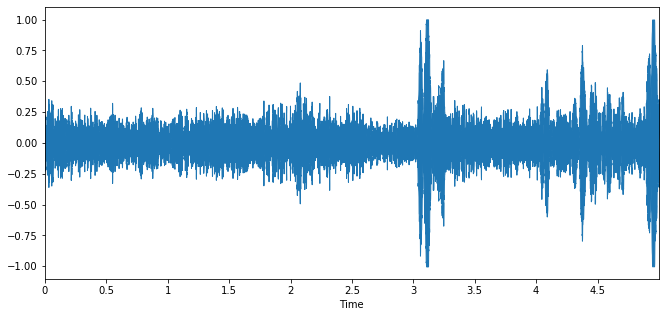

In [193]:
#
# Anzeige als PCM Kurven
#
displayIndex = 1
x_show = x_check[displayIndex]

plt.figure(figsize=(11, 5))
librosa.display.waveplot(x_show, sr=sampleRate)

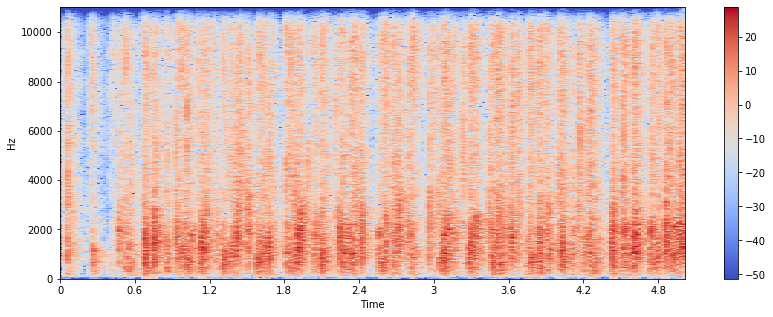

In [181]:
X = librosa.stft(x_show)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

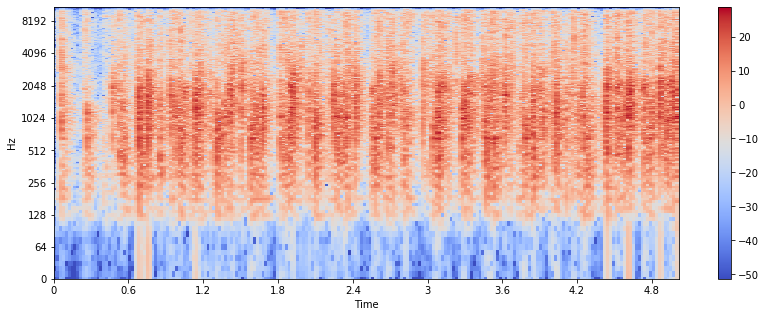

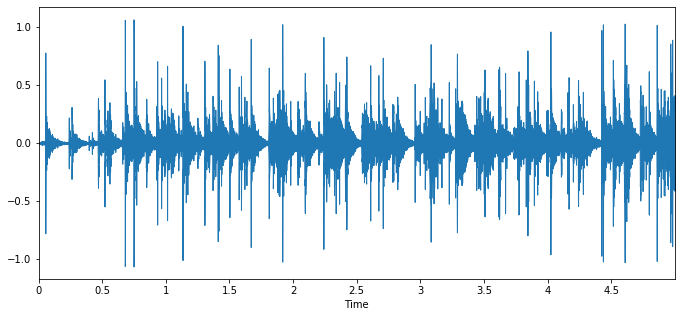

In [182]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.figure(figsize=(11.4, 5))
librosa.display.waveplot(x_show, sr=sampleRate)

In [178]:
from IPython.display import (
    Audio, display, clear_output)

In [184]:
display(Audio(x_show, rate=sampleRate, autoplay=True))

# Erzeugen der Trainingsdaten

In [203]:
#
#
#

# step size
window = 1024
# frequency pins
bins = 64



def get_features (file, hop, bins):
    
    y = np.zeros(sampleLen);   
    yt, sr = librosa.core.load (file, mono=True)
    
    if len(yt) == 0: 
        print ('found empty file ' + file )
        return 0

    min_length = min(len(y), len(yt))
    y[:min_length] = yt[:min_length]
    
    # https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    #C = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop, n_mfcc = bins)  

    #https://librosa.github.io/librosa/generated/librosa.core.cqt.html
    C = np.log1p( 1000 * np.abs (librosa.core.cqt( y=y, sr=sr, hop_length=hop, n_bins=bins)))
    
    return C

memory = joblib.Memory(cachedir=localExtractionFolder+'/esc50_joblib', verbose=0)
cached_get_features = memory.cache(get_features)


def compute_features (root_path):
    
        
    classes = 50
    samples = 0

    y_data = []    
    X_data = []
    
    for root, dir, files in os.walk(root_path):
        
        waves = fnmatch.filter(files, "*.wav")

        if len(waves) != 0:
            for item in waves:
                # e.g. 2-39443-A-19.wav
                fileName = os.path.splitext ( os.path.basename(item) )[0] 
                classID = int(fileName.split('-')[3])
                
                mfcc = cached_get_features( os.path.join(root, item), window, bins)
                print(".",end='')

                X_data.append(mfcc)
                y_data.append(classID)
                
                samples = samples + 1
                if samples >= 100:
                    break

    X_data = np.stack(X_data, axis=2)
    
    print('shape features {}'.format(X_data.shape))
    
    X_data = np.transpose(X_data, (2,0,1))
    d1 = X_data.shape[0]
    d2 = X_data.shape[1]
    d3 = X_data.shape[2]    
    X_data = np.reshape(X_data, (d1,d2,d3,1))
    y_data = np.array(y_data)    

    print('shape transformed {}'.format(X_data.shape))

    print ("samples = " + str (samples))

    return X_data, y_data, classes, samples

In [204]:
x_data, y_data, classes, samples = compute_features (audioData)

..........shape features (64, 108, 10)
shape transformed (10, 64, 108, 1)
samples = 10


In [205]:
x_data = x_data.astype('float32')
y_data = y_data.astype('uint8')

# Anzeige der Features als Bild

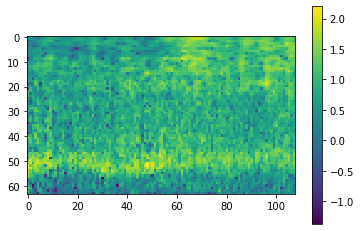

In [213]:
x_show = x_data[displayIndex]
x_show = np.reshape(x_show, (64,108))
#x_show = np.transpose(x_show,(1,0))
plt.imshow(x_show)
plt.colorbar()

# Normalisieren der Daten

In [209]:
def standardize (x):
    mu = np.mean (x, axis=0)
    de = np.std (x, axis=0)
    
    eps = np.finfo('float32').eps
    x = (x - mu) / (eps + de)
    return x


In [210]:
x_data = standardize(x_data)

In [211]:
# convert class vectors to binary class matrices
y_data = np_utils.to_categorical(y_data, classes )

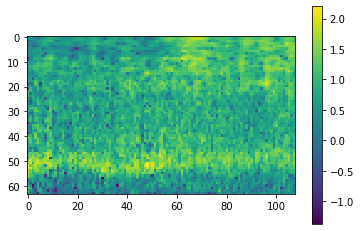

In [214]:
#
# Nochmals checken
#
x_show = x_data[displayIndex]
x_show = np.reshape(x_show, (64,108))
#x_show = np.transpose(x_show,(1,0))
plt.imshow(x_show)
plt.colorbar()


# Train und Test Split

In [134]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
x_train, x_validation, y_train, y_validation = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

print('shapes {} {} {} {}'.format(x_train.shape, x_validation.shape, y_train.shape, y_validation.shape ))

shapes (750, 100, 54, 1) (250, 100, 54, 1) (750, 50) (250, 50)


# Model bauen

In [135]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=5, strides=1, border_mode='same', input_shape=(img_rows, img_cols, 1)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, kernel_size=3, strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
     
    model.add(Convolution2D(64, kernel_size=3, strides=1, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, kernel_size=3, strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model


In [136]:
model_cnn = createModel()
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 100, 54, 32)       832       
_________________________________________________________________
activation_26 (Activation)   (None, 100, 54, 32)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 98, 52, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 98, 52, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 26, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 49, 26, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 49, 26, 64)       

In [144]:
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam ()
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [145]:
#
# Anlegen des Datengenerators mit Augmentierung
#
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

In [146]:
datagen.fit(x_train)

In [147]:
callbacks = [History()]
#callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto'), History()]

In [215]:
model_cnn.fit_generator(datagen.flow(x_train, y_train,
                            batch_size=64),
                            samples_per_epoch=x_train.shape[0],
                            nb_epoch=600,
                            callbacks=callbacks,
                            validation_data=(x_validation, y_validation))

Epoch 1/600
11/11 [==============================] - 13s 1s/step - loss: 2.7418 - accuracy: 0.2405 - val_loss: 3.1417 - val_accuracy: 0.2080
Epoch 2/600
11/11 [==============================] - 11s 998ms/step - loss: 2.7406 - accuracy: 0.2332 - val_loss: 3.0877 - val_accuracy: 0.1840
Epoch 3/600
11/11 [==============================] - 12s 1s/step - loss: 2.7991 - accuracy: 0.2318 - val_loss: 2.9483 - val_accuracy: 0.2080
Epoch 4/600
11/11 [==============================] - 12s 1s/step - loss: 2.7215 - accuracy: 0.2543 - val_loss: 2.9702 - val_accuracy: 0.2000
Epoch 5/600
11/11 [==============================] - 11s 970ms/step - loss: 2.6791 - accuracy: 0.2434 - val_loss: 2.8797 - val_accuracy: 0.2320
Epoch 6/600
11/11 [==============================] - 10s 953ms/step - loss: 2.6973 - accuracy: 0.2560 - val_loss: 2.9988 - val_accuracy: 0.2000
Epoch 7/600
11/11 [==============================] - 11s 977ms/step - loss: 2.6302 - accuracy: 0.2685 - val_loss: 3.0399 - val_accuracy: 0.2240
E

In [224]:
score = model_cnn.evaluate(x_validation, y_validation, verbose=0)
print("validation {} {:.3f}" .format(model_cnn.metrics_names[1], score[1]))

validation accuracy 0.220


In [219]:
#
# Speichern des Modelles
#
from keras.models import model_from_json
prefix = 'results/06_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

In [220]:
model_json = model_cnn.to_json()
with open( modelName , "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_cnn.save_weights( weightName )
print("saved model to disk as {} {}".format(modelName,weightName))

saved model to disk as results/06_model.json results/06_model.h5


In [ ]:
#
# Laden des Modelles
#
json_file = open(modelName, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weightName)
print("loaded model from disk")

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
score = loaded_model.evaluate(x_validate, y_validate, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))